In [149]:
import warnings
warnings.filterwarnings("ignore")
import argparse


import sys


import os
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt


import time




In [150]:
class NeuralNet:
    def __init__(self, layers_dims, activations_fnc,  type_="classif"):
        self.type_ = type_
        self.W = [None] * (len(layers_dims)-1)
        self.b = [None] * (len(layers_dims)-1)
        self.out = [None] * (len(layers_dims)-1)
        self.layers_dims = layers_dims
        self.activations_fnc = activations_fnc
        for i in range(len(layers_dims)-1):
            self.b[i] = np.random.randn(layers_dims[i+1]).reshape(1, layers_dims[i+1])
            self.W[i] = np.random.randn(layers_dims[i], layers_dims[i+1])
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
        
    def tanh(self, x):
        return np.tanh(x)
        
    def relu(self, x):
        return np.maximum(x, 0)
    
    def identity(self, x):
        return x
    
    def softsign(self,x):
        return x / (1 + np.abs(x))
        
    def sin(self, x):
        return np.sin(x)
    
    def cos(self, x):
        return np.cos(x)
        
    def softmax(self, x):
        exp_scores = np.exp(x)
        out = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return out
        
    def activation(self, x, t):
        t = t.lower()
        if t == "sigmoid":
            return self.sigmoid(x)
        elif t == "tanh":
            return self.tanh(x)
        elif t == "relu":
            return self.relu(x)
        elif t == "identity":
            return self.identity(x)
        elif t == "softsign":
            return self.softsign(x)
        elif t == "sin":
            return self.sin(x)
        elif t == "cos":
            return self.cos(x)
        elif t == "softmax":
            return self.softmax(x)
        else:
            raise Exception("Non-supported activation function {}".format(t))
            
    def multiply(self, x, W):
        m = np.dot(x, W)
        return m
    
    def add(self, m, b):
        return m + b
            
    def forward(self, x):
        input_ = x
        for i, activation in enumerate(self.activations_fnc) :
            weighted_sum = self.multiply(x=input_, W=self.W[i])
            weighted_sum = self.add(m=weighted_sum, b=self.b[i])
            input_ = self.out[i] = self.activation(x=weighted_sum, t=activation)

In [151]:
def hsv_to_rgb(h, s, v):
    ## hsw are between 0 and 1
    ## returns rgb between 0 and 1
    ## from: https://bgrins.github.io/TinyColor/docs/tinycolor.html
    h *= 6
    i = np.floor(h)
    f = h-i 
    p = v*(1-s)
    q = v*(1-f*s)
    t = v*(1-(1-f)*s)
    mod = int(i % 6)
    r = [v, q, p, p, t, v][mod]
    g = [t, v, v, q, p, p][mod]
    b = [p, p, t, v, v, q][mod]
    
    return r,g,b

def hsl_to_rgb(h, s, l):
    ## hsl are between 0 and 1
    ## returns rgb between 0 and 1
    
    def hue_to_rgb(p, q, t):
        if t < 0:
            t += 1
        if t > 1:
            t -= 1
        if t < 1/6:
            return p+(q-p)*6*t
        if t < 1/2:
            return q
        if t < 2/3:
            return p+(q-p)*(2/3-t)*6
        
    if s==0:
        r = g = b = l #achromatic
    else:
        if l < 0.5:
            q = l*(1+s)
        else:
            q = l+s-l*s
        p = 2*l-q
        r = hue_to_rgb(p, q, h + 1/3)
        g = hue_to_rgb(p, q, h)
        b = hue_to_rgb(p, q, h - 1/3)
        
        return r,g,b

In [152]:
def prep_nnet_arch(n_depth, n_size, activation, colormode, alpha):
    layers = [5] #x, y, r, z1, z2
    for i in range(n_depth):
        layers.append(n_size)
    
    colormode = colormode.lower()
    
    ### Output layer. Append number of output neurons depending on which colormode is selected
    if colormode in ["rgb", "hsv", "hsl"] : #RGB
        if not alpha:
            layers.append(3)
        else:
            layers.append(4)
    elif colormode == "cmyk":
        if not alpha:
            layers.append(4)
        else:
            layers.append(5) 
    elif colormode == "bw":
        if not alpha: 
            layers.append(1)
        else:
            layers.append(2)
    else:
        print("Inserted colormode '{}' is not part ob supported ones: [rgb, bw, cmyk, hsv, hsl]".format(colormode))
        raise Exception("Non-supported colormode {}".format(colormode))
    
    possibles = ["sigmoid", "tanh", "relu", "identity", "softsign", "sin", "cos", "softmax"]
    if not activation.lower() in possibles:
        print('defined activation {} not supported in {}'.format(activation, str(possibles)))
        return None
        
    activations_fnc = [activation] * (len(layers)-2)
    activations_fnc.append("sigmoid")
    
    return layers, activations_fnc   

In [153]:
n_depth = 4
n_size = 8
activation = "tanh"
colormode = "rgb"
alpha = True
layers, activations_fnc = prep_nnet_arch(n_depth, n_size, activation, colormode, alpha)
print("layers: {}".format(str(layers)))
print("activations: {}".format(str(activations_fnc)))

layers: [5, 8, 8, 8, 8, 4]
activations: ['tanh', 'tanh', 'tanh', 'tanh', 'sigmoid']


In [154]:
def get_color_at(nnet, x, y, r,  z1, z2, colormode, alpha):
    input_ = np.array([x, y, r, z1, z2], dtype=np.float32).reshape(1, 5)
    nnet.forward(input_)
    
    colormode = colormode.lower()
    
    if colormode == "rgb": ## Output via sigmoid activation mapped into range [0,1]
        r = nnet.out[len(nnet.out)-1][0][0]
        g = nnet.out[len(nnet.out)-1][0][1]
        b = nnet.out[len(nnet.out)-1][0][2]
        a_index = 3
    elif colormode == "bw":
        r=g=b = nnet.out[len(nnet.out)-1][0][0]
        a_index = 1
    elif colormode == "cmyk":
        c = nnet.out[len(nnet.out)-1][0][0]
        m = nnet.out[len(nnet.out)-1][0][1]
        y = nnet.out[len(nnet.out)-1][0][2]
        k = nnet.out[len(nnet.out)-1][0][3]
        r = (1-c)*k
        g = (1-m)*k
        b = (1-y)*k
        a_index = 4
    elif colormode == "hsv":
        h = nnet.out[len(nnet.out)-1][0][0]
        s = nnet.out[len(nnet.out)-1][0][1]
        v = nnet.out[len(nnet.out)-1][0][2]        
        r, g, b = hsv_to_rgb(h, s, v)
        a_index = 3
    elif colormode == "hsl":
        h = nnet.out[len(nnet.out)-1][0][0]
        s = nnet.out[len(nnet.out)-1][0][1]
        l = nnet.out[len(nnet.out)-1][0][2]  
        r, g, b = hsl_to_rgb(h, s, l)
        a_index = 3
    else:
        print("Inserted colormode '{}' is not part ob supported ones: [rgb, bw, cmyk, hsv, hsl]".format(colormode))
        raise Exception("Non-supported colormode {}".format(colormode))
    if alpha: 
        # Since non blackmode [rgb, cmyk, hsv, hsl] values are mapped onto [0,1] the alpha channel is also between [0,1].
        #0=transparency, 1=opaque wrt. to overlaying
        a = 1-abs(2*nnet.out[len(nnet.out)-1][0][a_index]-1)
        a = 0.25 + 0.75*a
    else:
        a = 1.0
    
    return r, g, b, a

In [155]:
def generate_image(img_height, img_width, n_depth, n_size, activation, colormode, alpha, z1, z2,
                   fname="netart.png", nnet_dict=None, save=False, show=False):
    factor = min(img_height, img_width)
    if nnet_dict is None:
        layers, activations_fnc = prep_nnet_arch(n_depth, n_size, activation, colormode, alpha)
    else:
        try:
            layers = nnet_dict["layers"]
            activations_fnc = nnet_dict["activations_fnc"]
            assert len(activations_fnc) == len(layers)-1
            assert layers[0] == 5
            assert activations_fnc[-1].lower() in ["sigmoid", "softmax"] 
        except Exception as e:
            print(e)
        
    nnet = NeuralNet(layers, activations_fnc) 
    img = init_image(img_height, img_width)
    for i in range(img_height):
        for j in range(img_width):
            x = i/factor - 0.5
            y = j/factor - 0.5
            r_ = np.sqrt(x*x + y*y)
            #Get RGBA values
            r, g, b, a = get_color_at(nnet, x=x, y=y, r=r_,
                                   z1=z1, z2=z2, colormode=colormode, alpha=alpha)
            #Populate the image
            img[i, j, 0] = r
            img[i, j, 1] = g
            img[i, j, 2] = b
            img[i, j, 3] = a
    
    if not show:
        matplotlib.use("Agg")
    
    plt.figure()    
    fig = plt.imshow(img, interpolation="bilinear", aspect="auto")
    plt.axis("off")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    if show:
        plt.show()
    
    if save:
        plt.imsave("{}".format(fname), img, format="png")
        
    return img

In [156]:
## This is fix
def init_image(rows,cols):
    img = np.zeros(shape = (rows,cols,4))
    return img

img_height = img_width = 256
activation = "tanh"

In [157]:
def randomize_configs():
    n_size = int(np.random.randint(low=12, high=20, size=1))
    n_depth = int(24 - n_size)
    colormode = np.random.choice(a=["rgb", "bw", "cmyk", "hsl", "hsv"], size=1)[0]
    alpha = bool(np.random.choice(a=[True, False], size=1))
    z1 = float(np.round(np.random.uniform(low=-1.0, high=1.0, size=1), decimals=5))
    z2 = float(np.round(np.random.uniform(low=-1.0, high=1.0, size=1), decimals=5))
    
    return n_size, n_depth, colormode, alpha, z1, z2

In [158]:
n_images = 1
if not os.path.exists("nb_output"):
    os.makedirs("nb_output")

Settings:
n_size: 16
n_depth: 8
colormode: rgb
alpha: True
z1: 0.42166
z2: 0.82701
--------
Generated image: 1


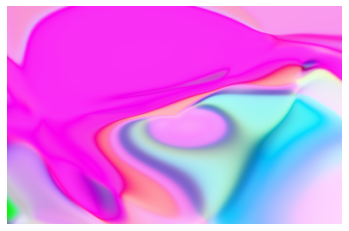

Generating image 1 took 4.878966569900513 seconds


In [159]:
for i in range(n_images):
    n_size, n_depth, colormode, alpha, z1, z2 = randomize_configs()
    print("Settings:")
    print("n_size: {}".format(n_size))
    print("n_depth: {}".format(n_depth))
    print("colormode: {}".format(colormode))
    print("alpha: {}".format(alpha))
    print("z1: {}".format(z1))
    print("z2: {}".format(z2))
    print("--------")
    fname = "nb_output/generated_{}_{}.png".format(colormode, i+1)
    print("Generated image: {}".format(i+1))
    start_time = time.time()
    generate_image(img_height, img_width, n_depth, n_size, activation, colormode, alpha, z1, z2,
                   show=True, nnet_dict=None, fname=fname, save=True)
    delta = time.time() - start_time
    print("Generating image {} took {} seconds".format(i+1, delta))